---
layout: post 
comments: true 
tags: dementia feature-engineering clustering data-preparation R-stats RNA-seq
title: Using Clustering Results to Define New Features for Modeling
---

In [1]:
setwd('..')

Hi, everyone! In the [last post](http://blog.vislaywade.com/clustering-experiments-feature-engineering-with-clValid/) to this blog, we talked about how to use the `clValid` package for R to try multiple different clustering algorithms with a range of different values for the number of clusters, $k$, in a single function call. In this post, we go one step further and use the results of a clustering experiment to create new features to put into models.  

#### On tap for this post:  

1. *Load Libraries & Data* - If you're running the Jupyter notebook version of this post from a cloned copy of the [project repository](https://github.com/brilliantFire/Allen-aging-dementia-TBI) on GitHub, the code blocks in this section will get you all set up.  
2. *$k$-Medoids Clustering Using CLARA* - We'll use the CLARA (Clustering Large Applications) algorithm to perform $k$-medoids clustering on gene expression levels for genes that [were identified](http://blog.vislaywade.com/EDA-gene-expression-data-part-3-results-visualizations/) as being differentially-expressed in the hippocampus (a region of the brain involved in memory formation) of dementia patients. We'll also produce some visualizations!  
3. *Extracting Cluster Medoids & Creating New Features* - The `cluster` package makes it very easy to extract the medoid values for each sample.  
4. *Reshaping a Dataset & Adding The New Features* - We'll reshape a table consisting of pathological and other measurements taken from multiple samples from the same patients then add our new variables to it to get it in shape for model building.  

Let's do it!

### Load Libraries & Data  
The `clara()` method is available in the `cluster` package along with a whole slew of other clustering algorithms. [CLARA](http://www.sthda.com/english/articles/27-partitioning-clustering-essentials/89-clara-clustering-large-applications/) is a way of doing *$k$-medoids* clustering on larger numbers of observations. We only have 277 genes that we're trying to cluster in this example so we could just as well use `pam()`, which is also available in the `cluster` package. I found there to be no difference between the two on this data.  

In [2]:
library(data.table)     # I/O
library(cluster)        # CLARA clustering algorithm

Warning message:
"package 'cluster' was built under R version 3.4.4"

Now we'll load the data we need, which consists of:  

1. *A normalized table of FPKM values* - These are the gene expression levels from RNA-seq experiments that have been normalized for both gene length and between-sample technical variation. Once again, this open-source data is available from the "Downloads" section of the [*Aging, Dementia, and TBI Study*](http://aging.brain-map.org/) website from the [Allen Institute for Brain Science](https://alleninstitute.org/what-we-do/brain-science/).  

2. *Information about the samples & donors* - This contains donor demographic and medical history information but, more importantly for our purposes, it has the variables that connect the brain tissue samples for which we have gene expression information to the donors they come from.  

3. *Brain region-specific lists of genes that appear to be differentially-expressed in samples from donors with dementia* - These are the genes that we [identified](http://blog.vislaywade.com/EDA-gene-expression-data-part-2-hypothesis-testing/) as having different expression patterns in dementia patients (check out [this post](http://blog.vislaywade.com/EDA-gene-expression-data-part-3-results-visualizations/) for additional visualizations and information).  

4. *Gene Information* - This is a table of Entrez Gene identification numbers (those are the row names in our FPKM matrix), gene symbols, and gene names.   

5. *Gene Annotation Lists* - In the [last post](http://blog.vislaywade.com/clustering-experiments-feature-engineering-with-clValid/) about the project, we used the `mygene` package from [Bioconductor](https://www.bioconductor.org/) to access [an open-source database](https://mygene.info/) of even more information about genes. We generated three lists of so-called *gene ontology* information regarding where the gene products are active, what they do, and which biological processes they're involved in. We'll use these lists together with the other information about genes (from #4) to learn about the medoids we'll use as cluster representatives. 

After loading the data, we'll make sure the gene expression data is a numeric matrix of scaled FPKM values and then subset it to contain only the hippocampus samples and the differentially expressed genes.

In [3]:
# load normalized FPKM values, sample info, DE gene lists for brain regions, annotations
fpkm_table <- readRDS(file='data/normalized_fpkm_matrix.Rds')
sample_info <- readRDS(file='data/sample_info.Rds')
brain_reg_sig_genes <- readRDS(file='data/brain_reg_sig_genes.Rds')
genes <- readRDS(file='data/genes.Rds')
annotations <- readRDS(file='data/hip_annotation_lists.Rds')

# make FPKM numeric matrix
fpkm_mat <- as.matrix(fpkm_table)
class(fpkm_mat) <- 'numeric'

# standardize
fpkm_standard_mat <- t(scale(t(fpkm_mat)))

# pull out individual brain region DE gene list
hip_genes <- brain_reg_sig_genes$hip_genes

# subset FPKM matrix to just HIP samples and HIP DE genes
hip_samples <- sample_info$rnaseq_profile_id[which(sample_info$structure_acronym == 'HIP')]
hip_data <- fpkm_standard_mat[hip_genes, colnames(fpkm_standard_mat) %in% hip_samples]

### $k$-Medoids Clustering Using CLARA  
[$k$-medoids](https://en.wikipedia.org/wiki/K-medoids) is a partitioning method much like $k$-means. The difference is that in $k$-medoids specific data points (called medoids) are representative of clusters instead of the means of the values in the cluster. Medoids are points in a cluster with the lowest average dissimilarity with all the other members of the cluster. Because it's based on medoids instead of means, $k$-medoids is considered more robust to noise than $k$-means.  

$k$-medoids can be computed using an algorithm called "partitioning around medoids", or *PAM*. CLARA (Clustering Large Applications) is special version of PAM that is performed on subsets. This has the advantage of speeding up computation on datasets with large numbers of observations. The optimal set of medoids are those which minimize the mean dissimilarity between every observation in the dataset and themselves. There's a solid overview of $k$-medoids and PAM [here](http://www.sthda.com/english/articles/27-partitioning-clustering-essentials/88-k-medoids-essentials/), and of CLARA [here](http://www.sthda.com/english/articles/27-partitioning-clustering-essentials/89-clara-clustering-large-applications/).  

Because of the sampling nature of CLARA, we'll have to specify both the number of samples (which is equivalent to the number of times PAM is performed) and the size of the samples. As with $k$-means, we need to pre-specifiy the value of $k$, the number of clusters. The optimal value of $k$ was determined using the `clValid` package we discussed in [the last post](http://blog.vislaywade.com/clustering-experiments-feature-engineering-with-clValid/). Below is a plot of the mean [silhouette value](https://en.wikipedia.org/wiki/Silhouette_(clustering)), a measure of how similar an observation is to the others in its cluster, versus $k$ generated using `clValid`. 

![clValid plot](../data/hip_k2-25_silhouette_plot.png)

We see that the highest average silhouette value for CLARA (red) was obtained using $k=3$. We'll run PAM on 1000 samples of 250 observations each.

In [4]:
# run CLARA on HIP FPKM values
hip_final_clara <- clara(hip_data, k=3, metric = 'euclidean',
                         samples=1000, sampsize=250, pamLike=TRUE)

The `cluster` package has a `plot()` function in it that produces two very helpful visualizations of the resulting clustering by CLARA. The first is a *principal component plot*, which plots the data along the first two principal components as a way of reducing the dimensionality so the data can be visualized. The second is a plot of the average silhouette values for the observations used to determine the clustering. We'll make the plots and discuss them in greater detail below.  

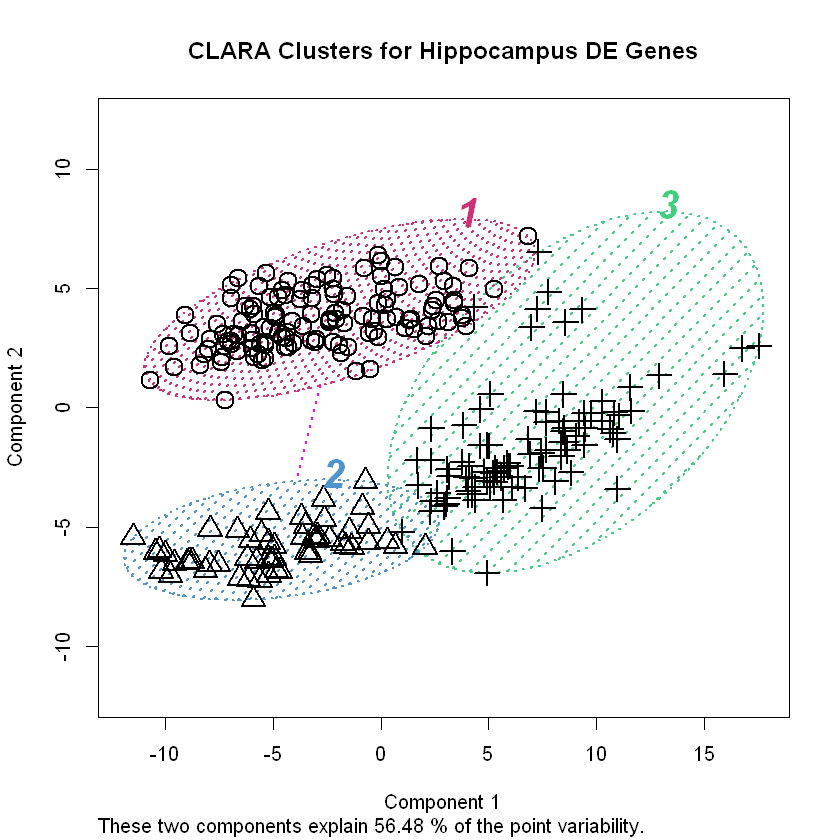

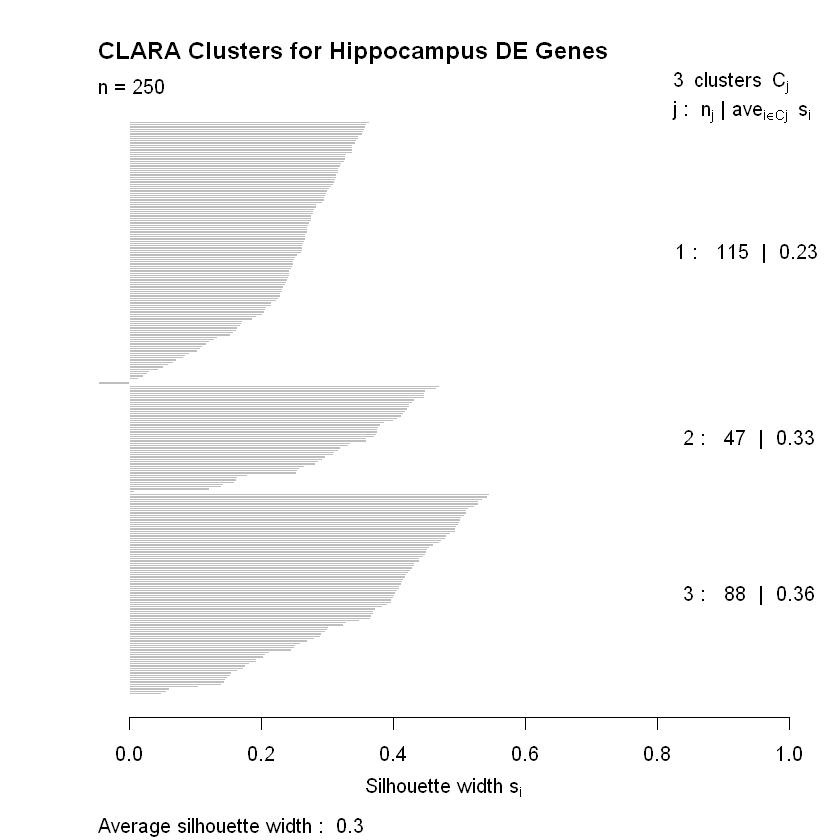

In [5]:
plot(hip_final_clara, color=TRUE, shade=TRUE, 
     labels=4, col.txt='black',
     col.p='black', col.clus=c('seagreen3', 'steelblue3', 'violetred3', 'sienna3'),
     cex=2, main = 'CLARA Clusters for Hippocampus DE Genes',
     ylim=c(-12,12),
     lwd=2,
     lty=3)

Using principal components to visualize clustering is a neat trick. Recall that principal components analysis results in a transformation of the data such that it resides in a space defined by a set of uncorrelated, orthogonal axes whereby the first direction accounts for the greatest amount of variance, the second accounts the next greatest amount, and so on. If there are natural groupings in the data, we might be able to visualize them in this new space. It's similar to the multidimensional scaling [we used on this data before](http://blog.vislaywade.com/EDA-gene-expression-data-part-1-multidimensional-scaling/). The `plot()` method for `clara()` objects draws normal confidence ellipses around the clusters to better visualize them. We can easily see where CLARA draws the $k=3$ clusters we instructed it to find.  

The second plot shows how well the observations fit into their clusters. Silhouette widths range from -1 to +1 with higher values indicating that the observation has a high degree of similarity with the others in its cluster. The silhouette values in the plot above are broken up by cluster. We're given the cluster number ($j$), the number of observations it has ($n_j$), and the clusterwise average silhouette width ($ave_{i \in C_j}$). We can see that only a few observations appear to be mis-clustered in cluster $j=1$ (they're the ones with negative silhouette widths so the bars point to the left).

### Extracting Cluster Medoids & Creating New Features  
With $k$-medoids, it's the values of an *observation* that serve to represent or summarize all the members of a cluster. In the present situation, that observation is a gene, and we want to use its expression levels as a new feature for constructing models of dementia risk in patients. We have three clusters so the three medoids for those clusters will be three new features. The `cluster` package makes it easy to find the medoids. They're in an attribute of the object we created when we used the `clara()` function. Here's a list of everything in that object, including the `medoids` attribute.

In [6]:
names(hip_final_clara)

[1] "sample"     "medoids"    "i.med"      "clustering" "objective" 
 [6] "clusinfo"   "diss"       "call"       "silinfo"    "data"

We'll pull `medoids` into a variable and take a look at them for the first 10 hippocampus samples.

In [7]:
hip_cluster_variables <- hip_final_clara$medoids
hip_cluster_variables[ , c(1:10)]

496100281  496100288  496100294  496100303  496100304  496100312 
26020  0.3317732 0.26347522  2.0606351  0.8543782  0.4829756  0.7175302
10769  1.6258326 1.38978200  0.8021832 -0.3410481  0.8054459  1.3898618
4674  -0.1452548 0.07374355 -0.7937299 -0.7605901 -0.2901150 -0.7495727
      496100313  496100314   496100319   496100321  
26020  0.4752763  0.06980942  0.08110504  0.08950004
10769  1.2999047  1.29193922  1.24369759  0.77390410
4674  -0.3333151 -0.20424814 -0.10017950 -1.00893383

The row names again are Entrez Gene database identification numbers. What are the names of the medoid genes? We can look in the `genes` table we loaded to find out!

In [8]:
genes[which(genes$gene_entrez_id %in% rownames(hip_cluster_variables)), ]

gene_id   chromosome gene_entrez_id gene_symbol
13930 499318611 5          10769          PLK2       
33926 499338662 14         26020          LRP10      
48716 499353496 X           4674          NAP1L2     
      gene_name                                          
13930 polo-like kinase 2                                 
33926 low density lipoprotein receptor-related protein 10
48716 nucleosome assembly protein 1-like 2

Where are these genes active in cells? What are they doing and what roles do they play in biological processes? We can take a look at the annotations we made last time to answer these questions. The `annotations` dataframe contains three lists for the three gene ontologies defined by the [Gene Ontology Consortium](http://www.geneontology.org/). They are:    

1. *Cellular Component (CC)* - This is where the gene product is found in cells or other biological structures.  

2. *Molecular Function (MF)* - This is what the gene product does.  

3. *Biological Process (BP)* - This is what the gene is important for (biologically-speaking).  

In [9]:
annotations[which(rownames(annotations) %in% rownames(hip_cluster_variables)), ]

CC            MF                                                
26020 membrane      low-density lipoprotein particle receptor activity
10769 intracellular protein serine/threonine kinase activity          
4674  nucleus       protein binding                                   
      BP                                 
26020 receptor-mediated endocytosis      
10769 regulation of centriole replication
4674  regulation of stem cell division

Now, this is only a partial annotation of these genes. They could have multiple entries for each ontology but when we made the lists we simplified things by only taking the most common entry for each. That having been said, the biological process ontologies for these guys fit fairly well with some of what we know about dementia and Alzheimer's disease$^{1,2}$.  

As much as I'd like to dig into the biology here, we're going to push on with the data science and talk about constructing a dataset for model building. 

### Reshaping a Dataset & Adding The New Features  
The goal of this project is to build models of dementia risk. To do that, we want our observations to be *people*. The problem is that we have multiple brain tissue samples from different parts of the brain for each donor. Let's take a look at the table containing all the molecular quantifications *besides* gene expression levels. We download it from the study website.

In [21]:
# Load Luminex protein, immunohistochemistry, and isoprostane quants
neuropath_data <- data.frame(fread('http://aging.brain-map.org/api/v2/data/query.csv?criteria=model::ApiTbiDonorMetric,rma::options[num_rows$eqall]'))
dim(neuropath_data)

[1] 377  33

There are 33 variables from 377 tissue samples taken from 107 donors.

In [22]:
head(names(neuropath_data))

[1] "donor_id"          "donor_name"        "structure_id"     
[4] "structure_acronym" "ihc_a_syn"         "ihc_tau2_ffpe"

What we need is a table with `donor_id` down the side and each molecular measurement *per brain region* across the top. We'll begin by dropping a couple of redundant variables, `donor_name` (not their actual name) and `structure_id`. We don't need these because, essentially, the same information is in the `donor_id` and `structure_acronym` variables, respectively.

In [12]:
# drop donor_name and structure_id (not needed)
cols_to_remove <- c('donor_name', 'structure_id')
neuropath_data <- neuropath_data[ , !(names(neuropath_data) %in% cols_to_remove)]

That should take us down to 31 columns.

In [13]:
dim(neuropath_data)

[1] 377  31

We can think of this data as being in "long format" with respect to `structure_acronym` when we'd rather have it in "wide format" (for a good discussion of the difference, see [this blog post](https://sejdemyr.github.io/r-tutorials/basics/wide-and-long/)). To get it into "wide format", with `donor_id` down the side and the quantifications *per brain region* across the top, we can use the [`reshape()` function](https://www.rdocumentation.org/packages/stats/versions/3.5.1/topics/reshape). For our purposes, we'll set the `idvar` argument equal to `donor_id`. That's the variable we want to identify our observations by. We set `timevar` equal to `structure_acronym` since we want to have our quantification variables *by brain region*, or structure. We'll take a look at the first few rows and a few random variables to see what `reshape()` does.

In [14]:
# reshape to wide format, donor_id down the side, variables by brain region across the top
reshaped <- reshape(neuropath_data, direction = 'wide', 
                    idvar = 'donor_id', timevar = 'structure_acronym')
reshaped[c(1:5), c(1, 12, 37, 68, 101)]

donor_id  vegf_pg_per_mg.FWM ihc_a_beta.PCx ihc_gfap_ffpe.TCx
1 309335467 0.33               0.046150806    0.02180811       
2 309335480 1.74               0.008108064    0.07107005       
3 309335493 1.02               0.069108488    0.03705643       
4 326765668 2.92               0.058136356    0.02333667       
6 467056408 0.00               0.013551929    0.03316191       
  tnf_a_pg_per_mg.HIP
1  5.00              
2    NA              
3 22.56              
4 26.98              
6 14.88

As you can see, R has added the brain region each quantification is from to the column name. FWM, PCx, and TCx stand for "forebrain white matter", "parietal cortex", and "temporal cortex", respectively. Those are the other three brain regions besides the hippocampus (HIP) in the dataset.

Now if we check the dimensions of the reshaped dataframe, we should have 107 rows (for 107 donors) and several more columns than the 31 we had before.

In [15]:
dim(reshaped)

[1] 107 117

Excellent! We'll go ahead and set the row names as `donor_id`.

In [16]:
# set donor_id as row names
rownames(reshaped) <- reshaped$donor_id
reshaped$donor_id <- NULL

Now, we're going to rename the rows and columns of the new hippocampus gene cluster variables. We'll give the variables names in the format that R has for the rest of the variables after reshaping them, with the structure acronym after a dot following the name of the quantification. The columns we'll label with the `donor_id`. Finally, we'll transpose so that we end up with donors down the side and the new variables across the top.

In [17]:
# change rownames
rownames(hip_cluster_variables) <- c('gene_cluster01.HIP', 'gene_cluster02.HIP', 'gene_cluster03.HIP')

# set colnames to donor_ids corresponding to rnaseq_profile_ids (colnames for hip_cluster_variables)
colnames(hip_cluster_variables) <- sample_info$donor_id[which(sample_info$rnaseq_profile_id %in% colnames(hip_cluster_variables))]

# transpose for merging
hip_cluster_variables <- t(hip_cluster_variables)

head(hip_cluster_variables)

gene_cluster01.HIP gene_cluster02.HIP gene_cluster03.HIP
309335438 0.3317732           1.6258326         -0.14525478       
309335439 0.2634752           1.3897820          0.07374355       
309335440 2.0606351           0.8021832         -0.79372987       
309335441 0.8543782          -0.3410481         -0.76059007       
309335442 0.4829756           0.8054459         -0.29011496       
309335443 0.7175302           1.3898618         -0.74957275

Now it's just a matter of merging the `reshaped` molecular quantification dataframe with the one containing the new gene cluster variables, `hip_cluster_variables`. The `reshaped` dataframe initially had 107 rows and 116 columns after we set `donor_id` as the row names. After setting `donor_id` as the row names in the new, merged dataframe, we should still have 107 rows but now have 119 columns since we will have added the three gene cluster variables.

In [18]:
# add HIP genetic variables
data_plus_hip <- merge(reshaped, hip_cluster_variables, by='row.names', all=TRUE)

# clean up row names
rownames(data_plus_hip) <- data_plus_hip$Row.names
data_plus_hip$Row.names <- NULL

dim(data_plus_hip)

[1] 107 119

That looks right! We can take a peak at the new variables, which were added to the very end of the table.

In [19]:
data_plus_hip[c(1:5), c(114:119)]

mip_1a_pg_per_mg.HIP il_7_pg_per_mg.HIP ab42_pg_per_mg.HIP
309335438  51.08               0.16                 0.2357875       
309335439 112.92               0.72                 0.3083375       
309335440     NA                 NA                        NA       
309335441  16.30               0.46               529.1107250       
309335442  35.42               1.80               315.7495250       
          gene_cluster01.HIP gene_cluster02.HIP gene_cluster03.HIP
309335438 0.3317732           1.6258326         -0.14525478       
309335439 0.2634752           1.3897820          0.07374355       
309335440 2.0606351           0.8021832         -0.79372987       
309335441 0.8543782          -0.3410481         -0.76059007       
309335442 0.4829756           0.8054459         -0.29011496

There they are! The dataset is starting to look like something we can use for building models of dementia risk. We just need to add gene expression level cluster variables for the the remaining three brain regions (FWM, PCx, & TCx) and some additional demographic and medical history data.  

Next time, we'll talk about using the finalized dataset to build models to predict dementia risk from this data. As you might have noticed, there's more features than samples ($p>n$) in our case so we'll discuss modeling strategies that can accomodate that situation.

Thanks for reading!

### References
1. Ubhi, K. & Masliah, E. (2013). Alzheimer’s Disease: Recent Advances and Future Perspectives. *J Alzheimers Res*. **33**: S185-S194.  

2. Marlatt MW, Lucassen PJ. (2010). Neurogenesis and Alzheimer's disease: Biology and pathophysiology in mice and men. *Curr Alzheimer Res*. **7**(2): 113-25. 